<a href="https://colab.research.google.com/github/tpenanen/Laptop-Price-Project/blob/main/Result_Analysis_(With_Pipeline%2C_Trying_to_remove_label_encoding_and_see_what_happens).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Label Encoding + Decision Tree done by Manbhav
Pipeline + Split + Lin Reg + KNN + Result Analysis + Pipeline Version edits done by Yasseen
Tree Regressor done by Tanmay
Clustering done by Aditya
Neural Network done by Yasseen + Manbhav

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/laptop_price.csv', encoding = 'latin1')
data.head()

Mounted at /content/drive


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Price_usd
0,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.0,436.7600
1,10,Acer,Swift 3,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.6kg,770.0,840.7630
2,37,Acer,Aspire 3,Notebook,15.6,1366x768,Intel Core i3 7130U 2.7GHz,4GB,1TB HDD,Intel HD Graphics 620,Linux,2.1kg,367.0,400.7273
3,44,Acer,Aspire A515-51G,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,4GB,256GB SSD,Intel UHD Graphics 620,Windows 10,2.2kg,682.0,744.6758
4,52,Acer,Aspire A515-51G,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Nvidia GeForce MX150,Windows 10,2.2kg,841.0,918.2879


In [4]:
data['target'] = (data['Price_usd']).astype(int)
del data['Price_usd']

In [5]:
categorical_columns = data.select_dtypes(include='object').columns.tolist()
print(categorical_columns)

['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight']


In [6]:
data_features = data.drop(["target", "Price_euros"], axis=1)

In [7]:
numfeat = ["Inches"]
catfeat = ["Product", "ScreenResolution", "Weight", "TypeName", "Cpu", "Ram", "Gpu", "OpSys", "Memory"]

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

cat_pipeline = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

full_pipeline = ColumnTransformer([("num", num_pipeline, numfeat), ("cat", cat_pipeline, catfeat)])

In [8]:
data.groupby("Company")["target"].mean().sort_values(ascending=False)

,target
Company,
Razer,3653.142857
LG,2291.333333
MSI,1887.277778
Google,1831.666667
Microsoft,1760.000000
Apple,1707.428571
Huawei,1554.000000
Samsung,1542.777778
Toshiba,1383.812500


In [9]:
data_features = data[numfeat + catfeat]
datafeatpp = full_pipeline.fit_transform(data_features)
display(datafeatpp)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13030 stored elements and shape (1303, 1129)>

Let's do a Linear Regression on our data! (Yasseen)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x = datafeatpp
y = data["target"].values

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(xtrain, ytrain)

y_pred = model1.predict(xtest)

print(f"R-squared score: {r2_score(ytest, model1.predict(xtest)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(ytest, y_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(ytest, y_pred):.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(ytest, y_pred):.2f}")

R-squared score: 0.75
Mean Absolute Error (MAE): 237.84
Mean Squared Error (MSE): 112790.88
Root Mean Squared Error (RMSE): 335.84


Let's visualize the basic linear regression

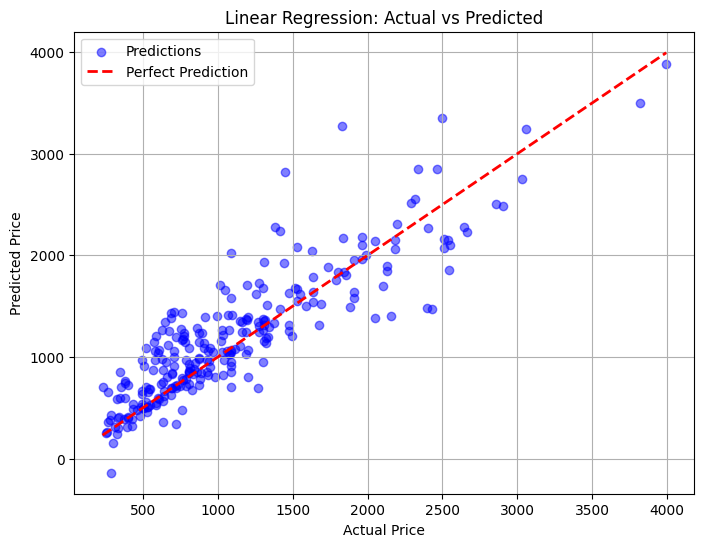

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, color='blue', label="Predictions", alpha = 0.5)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], '--', linewidth=2, label="Perfect Prediction", color = "red")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.grid(True)

So it might not be working well, so let's try L2 regularization since we want to keep features:

In [12]:
from sklearn.linear_model import RidgeCV
#First, let's try to find the best alpha value by using cross validation
alphas = [0.01, 0.1, 1, 10, 100]

ridgecv = RidgeCV(alphas = alphas, cv = 5)
ridgecv.fit(xtrain, ytrain)

print(f"The best alpha value is", ridgecv.alpha_)

The best alpha value is 1.0


In [51]:
from sklearn.linear_model import Ridge

modelrgde = Ridge(alpha = 1.2)
modelrgde.fit(xtrain, ytrain)
y_pred = modelrgde.predict(xtest)

print(f"R-squared score: {r2_score(ytest, modelrgde.predict(xtest)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(ytest, y_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(ytest, y_pred):.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(ytest, y_pred):.2f}")

R-squared score: 0.87
Mean Absolute Error (MAE): 176.25
Mean Squared Error (MSE): 60286.05
Root Mean Squared Error (RMSE): 245.53


Let's visualize it

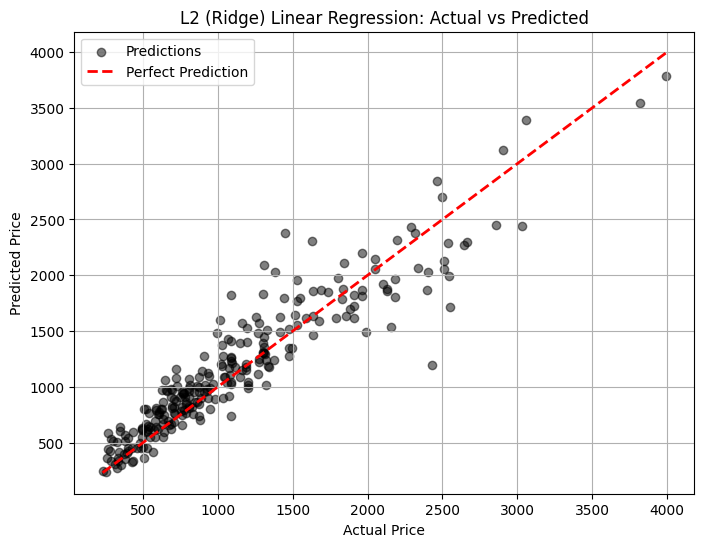

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, color='black', alpha=0.5, label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("L2 (Ridge) Linear Regression: Actual vs Predicted")
plt.legend()
plt.grid(True)

In [50]:
from sklearn import model_selection
als = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
for al in als:
  kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
  model = Ridge(alpha=al)
  result_kfold = model_selection.cross_val_score(model, xtrain, ytrain, cv=kfold)
  print('alpha=', al, 'mean accuracy=%.2f%%' % (result_kfold.mean() * 100.0))

alpha= 0.9 mean accuracy=83.05%
alpha= 1.0 mean accuracy=83.08%
alpha= 1.1 mean accuracy=83.09%
alpha= 1.2 mean accuracy=83.10%
alpha= 1.3 mean accuracy=83.09%
alpha= 1.4 mean accuracy=83.09%
alpha= 1.5 mean accuracy=83.08%


Great! It works even better now with L2 regression (ridge)! Note that our hyperparam, alpha, cannot be too high or too low as the model may underfit or overfit the data.

But what about L1 regression (lasso)?

In [15]:
from sklearn.linear_model import LassoCV
#First, let's try to find the best alpha value by using cross validation
alphas = [0.01, 0.1, 1, 10, 100]

lassocv = LassoCV(alphas = alphas, cv = 5)
lassocv.fit(xtrain, ytrain)

print(f"The best alpha value is", lassocv.alpha_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517225.88066464174, tolerance: 53481.76471068428
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436668.44828017615, tolerance: 51087.31623169268
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363423.30058347015, tolerance: 49029.02444808154
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: Conve

The best alpha value is 0.1


In [46]:
from sklearn.linear_model import Lasso

modelrgo = Lasso(alpha = 0.24)
modelrgo.fit(xtrain, ytrain)
y_pred = modelrgo.predict(xtest)

print(f"R-squared score: {r2_score(ytest, modelrgo.predict(xtest)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(ytest, y_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(ytest, y_pred):.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(ytest, y_pred):.2f}")

R-squared score: 0.88
Mean Absolute Error (MAE): 161.10
Mean Squared Error (MSE): 56178.49
Root Mean Squared Error (RMSE): 237.02


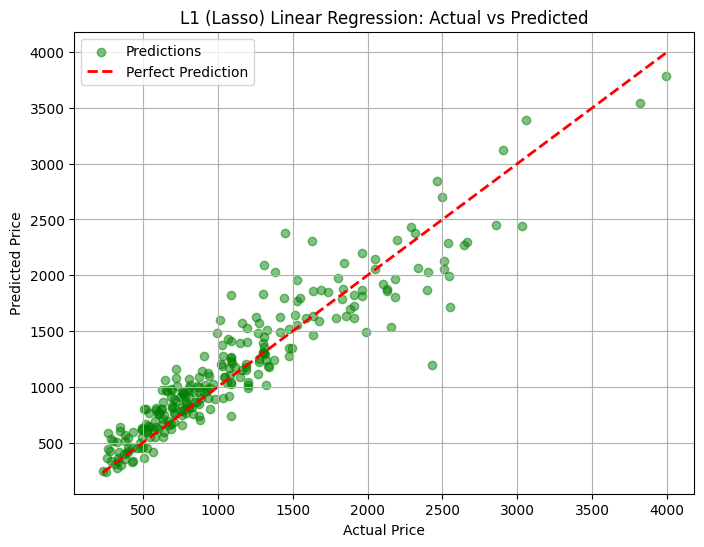

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, color='green', alpha=0.5, label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("L1 (Lasso) Linear Regression: Actual vs Predicted")
plt.legend()
plt.grid(True)

In [45]:
from sklearn import model_selection
als = [0.22, 0.23, 0.24, 0.25, 0.26]
for al in als:
  kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
  model = Lasso(alpha=al, tol=0.01)
  result_kfold = model_selection.cross_val_score(model, xtrain, ytrain, cv=kfold)
  print('alpha=', al, 'mean accuracy=%.2f%%' % (result_kfold.mean() * 100.0))

alpha= 0.22 mean accuracy=81.91%
alpha= 0.23 mean accuracy=81.92%
alpha= 0.24 mean accuracy=81.93%
alpha= 0.25 mean accuracy=81.91%
alpha= 0.26 mean accuracy=81.90%


Now we will look at KNN. Note that we may need the label encoded versions of the values for this. (Yasseen)

In [18]:
knn = KNeighborsRegressor(n_neighbors=6) #This was the best value I tested
knn.fit(xtrain, ytrain)
raw_predicted = knn.predict(xtest)

print(f"R-squared score: {r2_score(ytest, raw_predicted):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(ytest, raw_predicted):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(ytest, raw_predicted):.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(ytest, raw_predicted):.2f}")

R-squared score: 0.84
Mean Absolute Error (MAE): 179.42
Mean Squared Error (MSE): 73497.42
Root Mean Squared Error (RMSE): 271.10


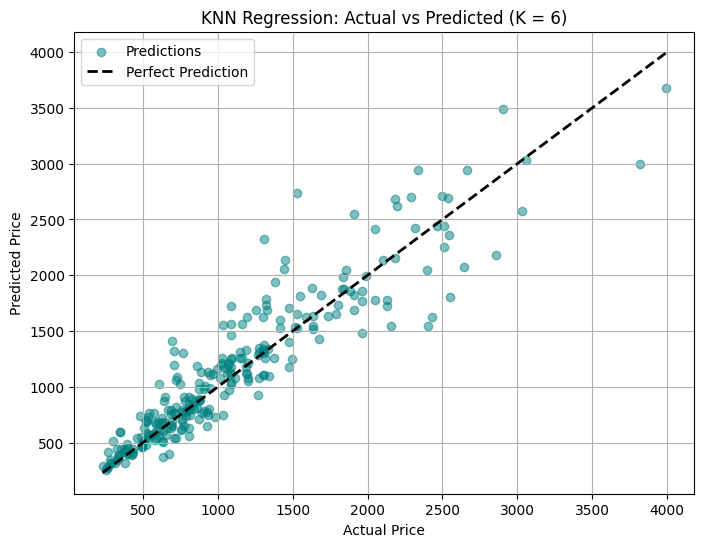

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, raw_predicted, color='teal', alpha=0.5, label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], '--', linewidth=2, label="Perfect Prediction", color = "black")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("KNN Regression: Actual vs Predicted (K = 6)")
plt.legend()
plt.grid(True)

Our R^2 score is not the best we can do, so let's see how it does with other K values in specific ranges. Since we already tried a range of 5-10, let's try 1-3, so 2. (k is hyperparam)

In [34]:
knn = KNeighborsRegressor(n_neighbors=2, p=2, weights="distance")

knn.fit(xtrain, ytrain)
raw_predicted = knn.predict(xtest)
print(f"R-squared score: {r2_score(ytest, raw_predicted):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(ytest, raw_predicted):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(ytest, raw_predicted):.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(ytest, raw_predicted):.2f}")

R-squared score: 0.85
Mean Absolute Error (MAE): 174.35
Mean Squared Error (MSE): 68920.36
Root Mean Squared Error (RMSE): 262.53


Let's plot out the KNN with our new value:

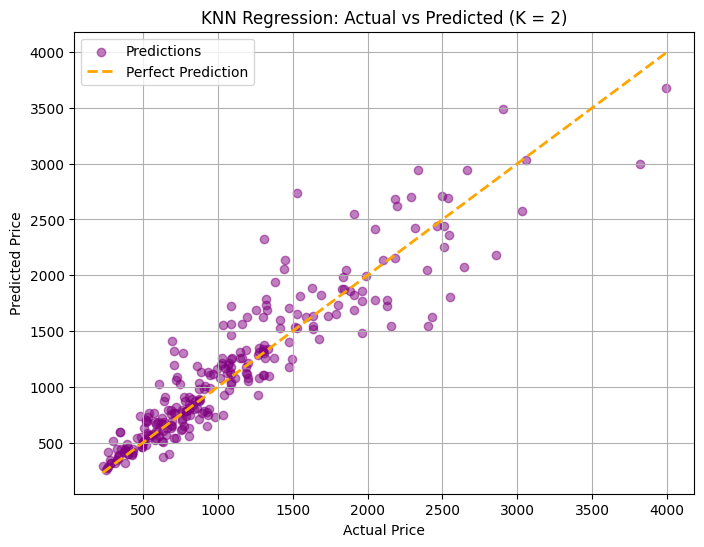

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, raw_predicted, color='purple', alpha=0.5, label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], '--', linewidth=2, label="Perfect Prediction", color = "orange")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("KNN Regression: Actual vs Predicted (K = 2)")
plt.legend()
plt.grid(True)

Now let's do a decision tree (Manbhav)

MAE: 227.94299150096214
MSE: 106709.87296603355
RMSE: 326.6647715411528
R² Score: 0.7636052985828673


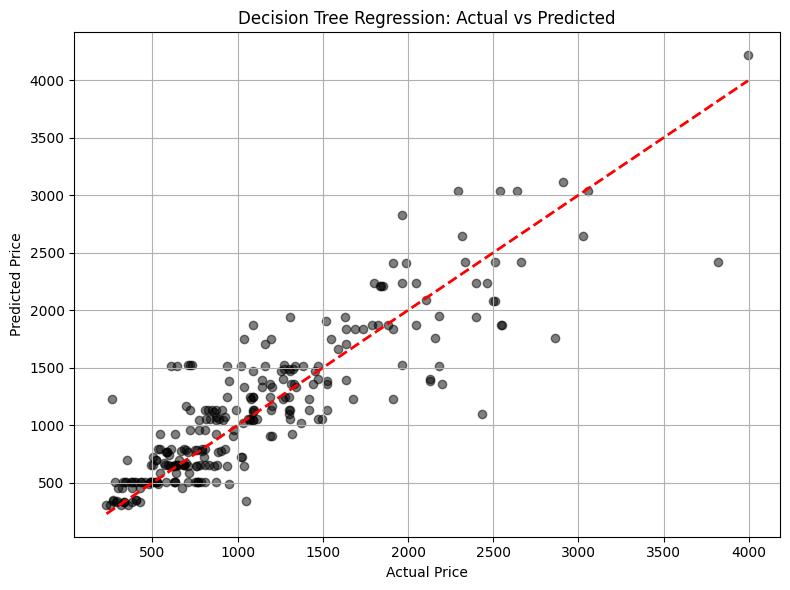

In [22]:
# this is our input features  list
X = datafeatpp
# output or target
y = data["target"].values

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Training the data


dtr = DecisionTreeRegressor(max_depth = 25,min_samples_leaf=5,max_leaf_nodes=92,random_state=42) # can add splitter = 'random' to reduce overfitting as well
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Decision Tree Regression: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


Let's visualize our tree:

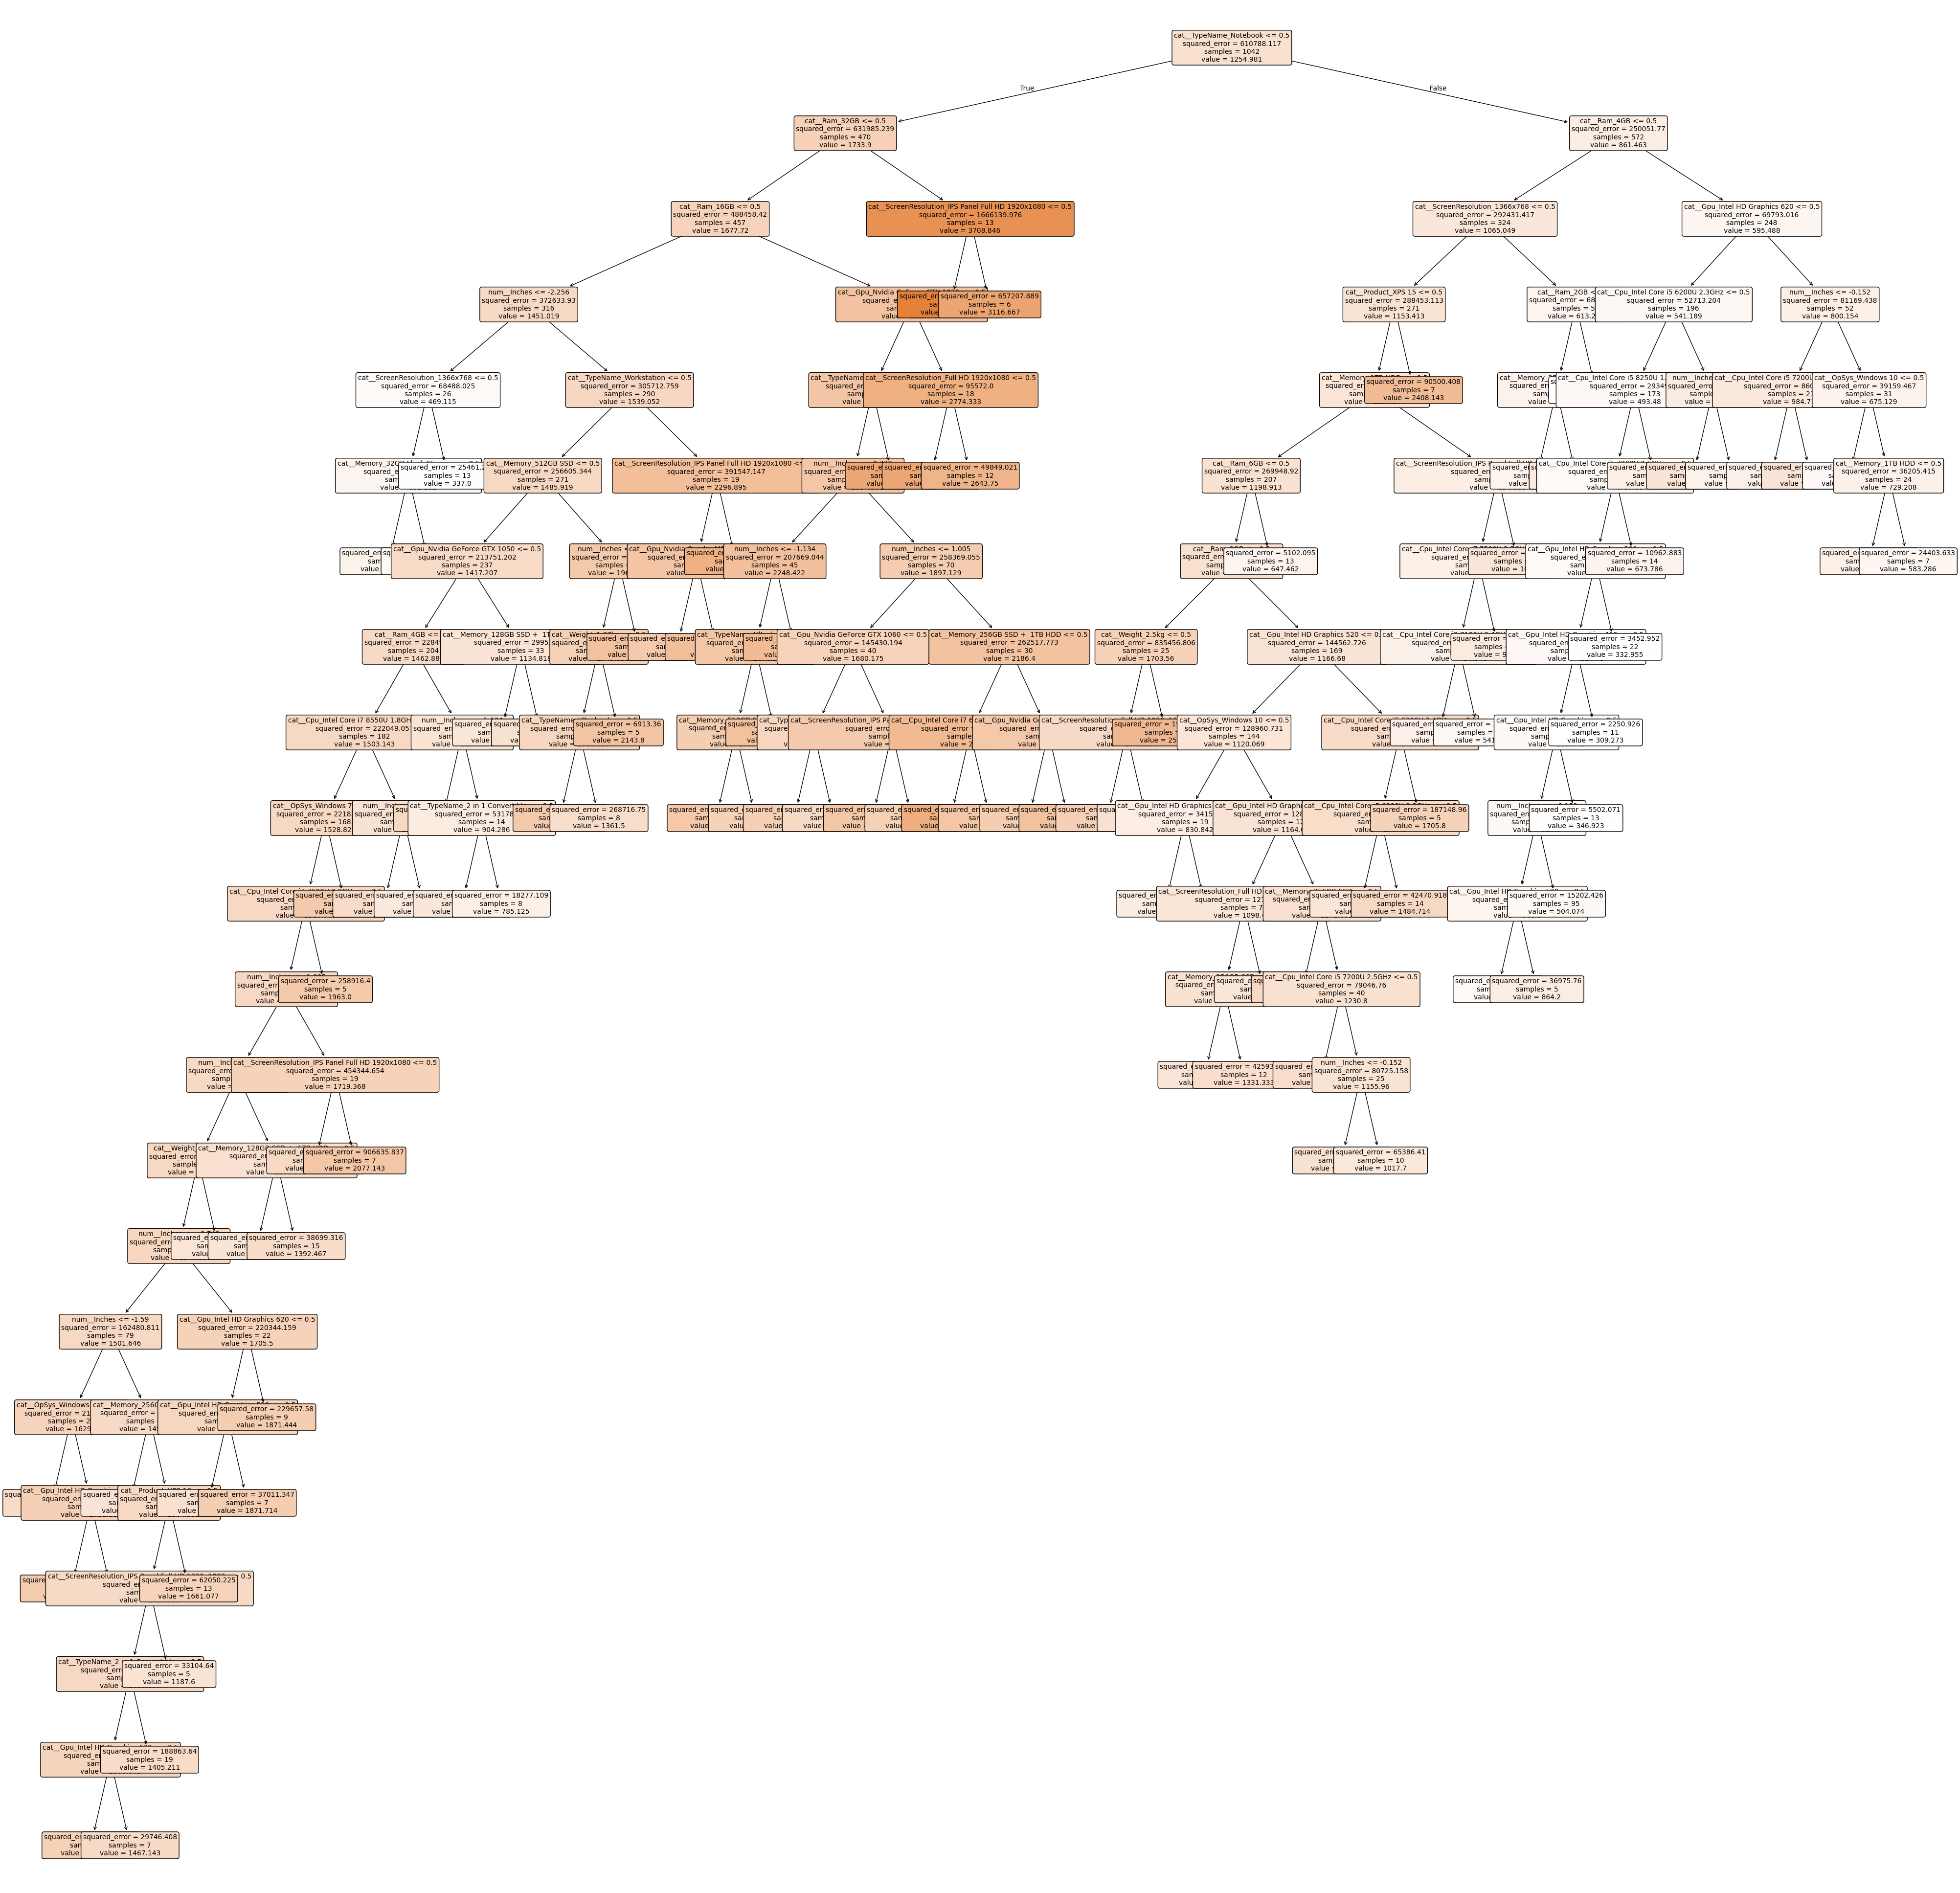

In [23]:
from sklearn import tree
feature_names = full_pipeline.get_feature_names_out()

plt.figure(figsize=(50,50))
tree.plot_tree(dtr, filled=True, feature_names=feature_names, rounded=True, fontsize=10)
plt.show()

Let's try to tune a hyperparameter on the tree

In [24]:
#FIGURING OUT BEST MAX_DEPTH
best_rmse = float('inf')
best_rmse_depth = None
best_rmse_mae = None
best_rmse_r2 = None

best_mae = float('inf')
best_mae_depth = None
best_mae_rmse = None
best_mae_r2 = None

best_r2 = float('-inf')
best_r2_depth = None
best_r2_rmse = None
best_r2_mae = None
for depth in range(1, 1000):
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    if rmse < best_rmse:
        best_rmse = rmse
        best_rmse_depth = depth
        best_rmse_mae = mae
        best_rmse_r2 = r2

    if mae < best_mae:
        best_mae = mae
        best_mae_depth = depth
        best_mae_rmse = rmse
        best_mae_r2 = r2

    if r2 > best_r2:
        best_r2 = r2
        best_r2_depth = depth
        best_r2_rmse = rmse
        best_r2_mae = mae

print("Best RMSE:", round(best_rmse, 3), "| Depth:", best_rmse_depth, "| MAE:", round(best_rmse_mae, 3), "| R²:", round(best_rmse_r2, 3))
print("Best MAE :", round(best_mae, 3), "| Depth:", best_mae_depth, "| RMSE:", round(best_mae_rmse, 3), "| R²:", round(best_mae_r2, 3))
print("Best R²  :", round(best_r2, 3), "| Depth:", best_r2_depth, "| RMSE:", round(best_r2_rmse, 3), "| MAE:", round(best_r2_mae, 3))

Best RMSE: 288.614 | Depth: 29 | MAE: 202.032 | R²: 0.815
Best MAE : 200.763 | Depth: 38 | RMSE: 290.363 | R²: 0.813
Best R²  : 0.815 | Depth: 29 | RMSE: 288.614 | MAE: 202.032


In [25]:
#FIGURING OUT BEST MIN_SAMPLES_LEAF
best_rmse = float('inf')
best_rmse_leaf = None
best_rmse_mae = None
best_rmse_r2 = None

best_mae = float('inf')
best_mae_leaf = None
best_mae_rmse = None
best_mae_r2 = None

best_r2 = float('-inf')
best_r2_leaf = None
best_r2_rmse = None
best_r2_mae = None

for leaf_size in range(1, 1000):
    model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=leaf_size, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    if rmse < best_rmse:
        best_rmse = rmse
        best_rmse_leaf = leaf_size
        best_rmse_mae = mae
        best_rmse_r2 = r2

    if mae < best_mae:
        best_mae = mae
        best_mae_leaf = leaf_size
        best_mae_rmse = rmse
        best_mae_r2 = r2

    if r2 > best_r2:
        best_r2 = r2
        best_r2_leaf = leaf_size
        best_r2_rmse = rmse
        best_r2_mae = mae

print("Best RMSE:", round(best_rmse, 3), "| min_samples_leaf:", best_rmse_leaf, "| MAE:", round(best_rmse_mae, 3), "| R²:", round(best_rmse_r2, 3))
print("Best MAE :", round(best_mae, 3), "| min_samples_leaf:", best_mae_leaf, "| RMSE:", round(best_mae_rmse, 3), "| R²:", round(best_mae_r2, 3))
print("Best R²  :", round(best_r2, 3), "| min_samples_leaf:", best_r2_leaf, "| RMSE:", round(best_r2_rmse, 3), "| MAE:", round(best_r2_mae, 3))

Best RMSE: 298.878 | min_samples_leaf: 1 | MAE: 207.583 | R²: 0.802
Best MAE : 207.583 | min_samples_leaf: 1 | RMSE: 298.878 | R²: 0.802
Best R²  : 0.802 | min_samples_leaf: 1 | RMSE: 298.878 | MAE: 207.583


In [26]:
#FIGURING OUT BEST MAX_LEAF_NODES
best_rmse = float('inf')
best_rmse_mae = None
best_rmse_r2 = None

best_mae = float('inf')
best_mae_rmse = None
best_mae_r2 = None

best_r2 = float('-inf')
best_r2_rmse = None
best_r2_mae = None

for leaf_nodes in range(2, 1000):
    model = DecisionTreeRegressor(max_depth=25,min_samples_leaf=5,max_leaf_nodes=leaf_nodes,random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    if rmse < best_rmse:
        best_rmse = rmse
        best_rmse_leaf_nodes = leaf_nodes
        best_rmse_mae = mae
        best_rmse_r2 = r2

    if mae < best_mae:
        best_mae = mae
        best_mae_leaf_nodes = leaf_nodes
        best_mae_rmse = rmse
        best_mae_r2 = r2

    if r2 > best_r2:
        best_r2 = r2
        best_r2_leaf_nodes = leaf_nodes
        best_r2_rmse = rmse
        best_r2_mae = mae

print("Best RMSE:", round(best_rmse, 3), "| max_leaf_nodes:", best_rmse_leaf_nodes, "| MAE:", round(best_rmse_mae, 3), "| R²:", round(best_rmse_r2, 3))
print("Best MAE :", round(best_mae, 3), "| max_leaf_nodes:", best_mae_leaf_nodes, "| RMSE:", round(best_mae_rmse, 3), "| R²:", round(best_mae_r2, 3))
print("Best R²  :", round(best_r2, 3), "| max_leaf_nodes:", best_r2_leaf_nodes, "| RMSE:", round(best_r2_rmse, 3), "| MAE:", round(best_r2_mae, 3))

Best RMSE: 315.531 | max_leaf_nodes: 57 | MAE: 227.438 | R²: 0.779
Best MAE : 224.689 | max_leaf_nodes: 137 | RMSE: 327.189 | R²: 0.763
Best R²  : 0.779 | max_leaf_nodes: 57 | RMSE: 315.531 | MAE: 227.438


Forest Tree:

In [27]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 20, random_state = 42, max_depth = 20, max_features = 2)
forest.fit(xtrain, ytrain)
forest_y_pred = forest.predict(xtest)
mae = mean_absolute_error(ytest, forest_y_pred)
print(f"R-squared score: {r2_score(ytest, raw_predicted):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(ytest, raw_predicted):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(ytest, raw_predicted):.2f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(ytest, raw_predicted):.2f}")

R-squared score: 0.84
Mean Absolute Error (MAE): 177.81
Mean Squared Error (MSE): 70485.27
Root Mean Squared Error (RMSE): 265.49


Now let's try to find the right hyperparam for the forest:

In [28]:
from sklearn import model_selection
estimators = [20, 50, 100]
depths = [20, 50, 100]
max_features = [1, 2, 5]
for estimator in estimators:
  for depth in depths:
    for max_feature in max_features:
      kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
      model = RandomForestRegressor(n_estimators=estimator, max_depth=depth, max_features=max_feature)
      result_kfold = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
      print('e=', estimator, 'depth=', depth, 'max features=', max_feature, 'mean accuracy=%.2f%%' % (result_kfold.mean() * 100.0))

e= 20 depth= 20 max features= 1 mean accuracy=21.34%
e= 20 depth= 20 max features= 2 mean accuracy=27.13%
e= 20 depth= 20 max features= 5 mean accuracy=47.30%
e= 20 depth= 50 max features= 1 mean accuracy=52.97%
e= 20 depth= 50 max features= 2 mean accuracy=55.45%
e= 20 depth= 50 max features= 5 mean accuracy=70.90%
e= 20 depth= 100 max features= 1 mean accuracy=76.26%
e= 20 depth= 100 max features= 2 mean accuracy=76.82%
e= 20 depth= 100 max features= 5 mean accuracy=79.49%
e= 50 depth= 20 max features= 1 mean accuracy=22.79%
e= 50 depth= 20 max features= 2 mean accuracy=29.46%
e= 50 depth= 20 max features= 5 mean accuracy=46.49%
e= 50 depth= 50 max features= 1 mean accuracy=51.51%
e= 50 depth= 50 max features= 2 mean accuracy=59.70%
e= 50 depth= 50 max features= 5 mean accuracy=71.60%
e= 50 depth= 100 max features= 1 mean accuracy=76.87%
e= 50 depth= 100 max features= 2 mean accuracy=77.99%
e= 50 depth= 100 max features= 5 mean accuracy=80.21%
e= 100 depth= 20 max features= 1 mean ac

Now let's make a neural network:

Iteration 1, loss = 1090281.34242910
Iteration 2, loss = 1067002.82554690
Iteration 3, loss = 996878.37609592
Iteration 4, loss = 850344.00066363
Iteration 5, loss = 620994.36488897
Iteration 6, loss = 381401.59327426
Iteration 7, loss = 265103.35940882
Iteration 8, loss = 219311.87162756
Iteration 9, loss = 149168.05145576
Iteration 10, loss = 113406.93833421
Iteration 11, loss = 89569.53252638
Iteration 12, loss = 72777.49999517
Iteration 13, loss = 62079.94142042
Iteration 14, loss = 52331.14660575
Iteration 15, loss = 44548.78952765
Iteration 16, loss = 38444.30429643
Iteration 17, loss = 33356.80384566
Iteration 18, loss = 29162.03526886
Iteration 19, loss = 25723.35684381
Iteration 20, loss = 22779.02312332
Iteration 21, loss = 20568.73570823
Iteration 22, loss = 18406.21706874
Iteration 23, loss = 16770.99281242
Iteration 24, loss = 15258.56123165
Iteration 25, loss = 14137.21154430
Iteration 26, loss = 13131.05266275
Iteration 27, loss = 12161.47592206
Iteration 28, loss = 1135

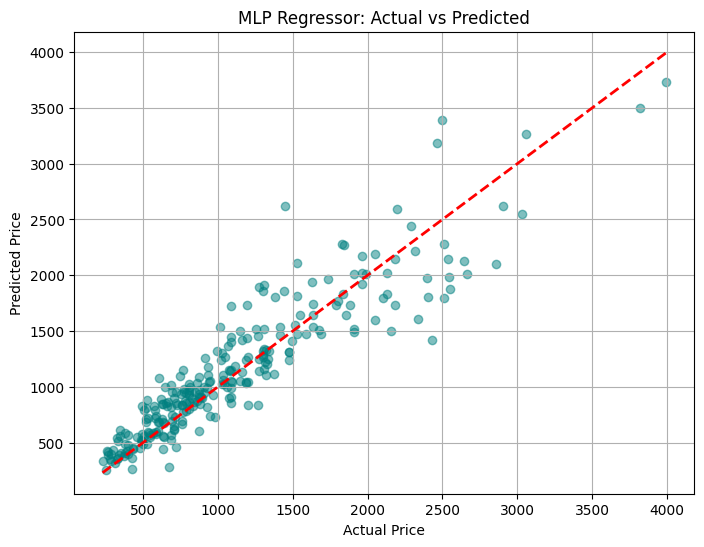

In [29]:
data_features = data[numfeat + catfeat]

x = full_pipeline.fit_transform(data_features)  # Transformed features from numeric and categorical pipeline
y = data["target"].values # The target variable of price_usd

#Do the split again just in case
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

# The structure was pretty hard to get
mlp = MLPRegressor(
    hidden_layer_sizes = (100, 50),     # Note for team: You guys can expirement with layer sizes, isn't a set amount
    activation = 'relu',                # ReLU activation function
    solver = 'adam',                    # Optimizer
    learning_rate_init = 0.01,          # Initial learning rate
    max_iter = 500,                     # Maximum number of training iterations for model
    random_state = 42,
    verbose = True
)

mlp.fit(xtrain, ytrain)

y_pred = mlp.predict(xtest)

mae = mean_absolute_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, y_pred)

print(f"R-squared Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, alpha=0.5, color='teal')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("MLP Regressor: Actual vs Predicted")
plt.grid(True)
plt.show()

Make a bar graph of the six regression types in order to see which model performs the best.

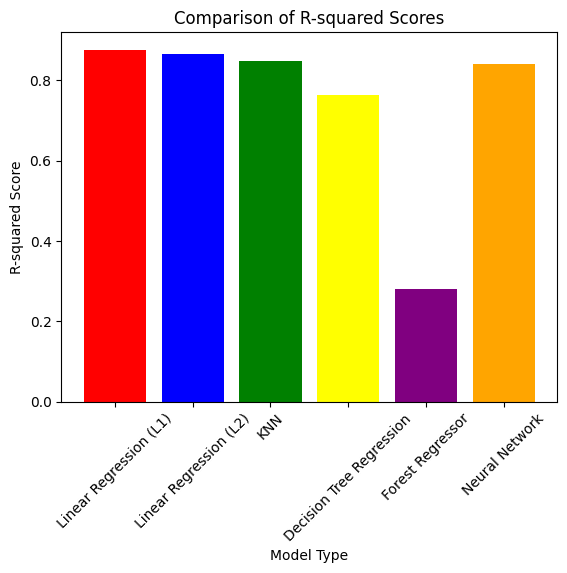

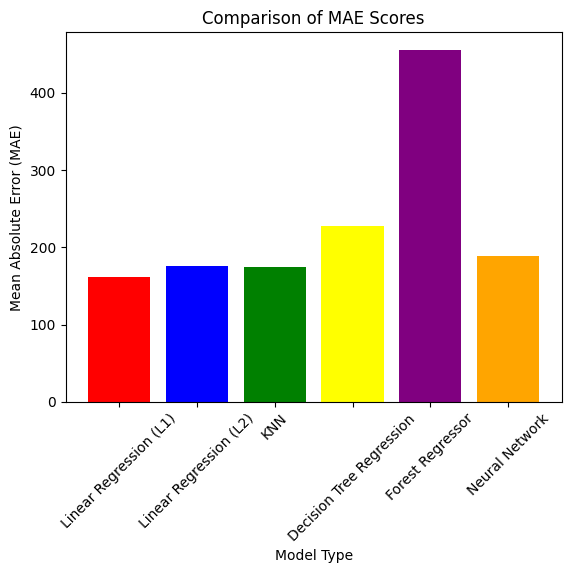

In [53]:
#This is the R squared score comparison
models = {"Linear Regression (L1)": modelrgo, "Linear Regression (L2)": modelrgde, "KNN": knn, "Decision Tree Regression": dtr, "Forest Regressor": forest, "Neural Network": mlp}
r2_scores = [r2_score(ytest, model.predict(xtest)) for model in models.values()]

plt.bar(models.keys(), r2_scores, color=["red", "blue", "green", "yellow", "purple", "orange"])
plt.xticks(rotation = 45)
plt.xlabel("Model Type")
plt.ylabel("R-squared Score")
plt.title("Comparison of R-squared Scores")
plt.show()

#This is the MAE comparison
models = {"Linear Regression (L1)": modelrgo, "Linear Regression (L2)": modelrgde, "KNN": knn, "Decision Tree Regression": dtr, "Forest Regressor": forest, "Neural Network": mlp}
mae_scores = [mean_absolute_error(ytest, model.predict(xtest)) for model in models.values()]

plt.bar(models.keys(), mae_scores, color=["red", "blue", "green", "yellow", "purple", "orange"])
plt.xticks(rotation = 45)
plt.xlabel("Model Type")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of MAE Scores")
plt.show()

L2 works the best with the pipeline version as the data has been scaled and onehot encoded. This is because lin reg is susceptible to scaling changes and it can have big effects on the model's performance. The problem is now the data is not correlated, so it results in L2 working really well, but forest regressor not performing as well. Since onehot causes data to become sparse, the forest may overfit. The tree depth may also be a factor if it is too high. Pipelines should be used on models like Linear Regression and KNN. The reason why forest regressor is performing way better without the pipeline is because the label encoding helps out a lot.

Try xgboost and catboost. Both random forest models that help out with forest regressor accuracy.

Try PCA (Takes n by d matrix to n by 2 matrix) --> You can plot xtrain as a result of using. It finds the two directions in d dimensional space that maximizes variance. Look at before and after for data preprocessing after using PCA.

Take out KNN and Decision Tree Regression and compare Forest Regressor to Manbhav's version as they're polar opposites. Still use xgboost and catboost on Forest Regressor.

All models seem to be fitting well with data as they are all near that 0.85 r-squared score range, all except for the forest regression. The forest regression is underfitting because of the reasoning from before. There are hundreds of sparse binary features as a result of the onehot encoding in the pipeline, causing the forest regression to treat each binary feature as its own split. This is why lin reg works so well with it, it likes to have many input values, but horrible for forest regression. The splits become noisy as a result of those dummy values. Also, the standard scaler used may also affect how the forest may fit on the data...
Since it scales continuous values, it may increase the complexity as a result and become unnessecary as the forest does not need scaled features. This also raises the question of why the decision tree isn't as affected...
Keep in mind, the forest is multiple trees in one, so if it has multiple trees affected by the scaler and one hot, then it can get messy.

Also, as a result of the pipeline creation, the label encoding made before will get thrown away as a result, meaning all the models have been using scaled and onehot encoded values.